## Подгружаем данные

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from catboost import Pool, CatBoostClassifier
from catboost.utils import select_threshold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
%%time
cat_features = np.load('cat_features.npy')
cat_features = np.delete(cat_features, np.where(cat_features == 'target'))

CPU times: total: 0 ns
Wall time: 1.22 ms


In [5]:
%%time
data = pd.read_parquet('train.parquet')

CPU times: total: 3.83 s
Wall time: 1.51 s


## Сжимаем данные

In [6]:
%%time
for col in data.columns:
    if data[col].dtype == 'int64':
        for two in [8, 16, 32, 64]:
            if data[col].min() >= 0 and data[col].max() < 2**two:
                data[col] = data[col].astype(f'uint{two}')
                break
            elif data[col].max() < 2**(two)//2 and abs(data[col].min()) < 2**(two)//2:
                data[col] = data[col].astype(f'int{two}')
                break

CPU times: total: 15.6 ms
Wall time: 28 ms


In [7]:
data.head()

,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9,feature12,feature17,feature18,feature19,feature22,feature23,feature24,feature25,feature26,feature27,feature30,feature31,feature33,feature35,feature36,feature37,feature38,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature52,feature53,feature56,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature120,feature121,feature122,feature123,feature124,feature125,feature127,feature128,feature133,feature136,feature137,feature138,feature139,feature140,feature141,feature143,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature199,feature200,feature202,feature203,feature204,feature205,feature208,feature210,feature212,feature214,feature215,feature216,feature217,feature218,feature220,feature224,feature225,feature226,feature227,feature229,feature230,feature231,feature232,feature233,feature234,feature243,feature244,feature260,feature262,feature264,feature265,feature268,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature315,feature316,feature318,feature320,feature321,feature322,feature324,feature325,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature349,feature350,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature366,feature367,feature368,feature369,feature370,feature376,feature383,feature384,feature385,feature386,feature387,feature388,feature390,feature391,feature392,feature393,feature394,feature395,feature399,feature400,feature401,feature404,feature405,feature408,feature409,feature410,feature411,feature412,feature413,feature415,feature416,feature417,feature418,feature420,feature422,feature423,feature424,feature425,feature426,feature427,feature428,feature429,feature431,feature433,feature434,feature435,feature437,feature439,feature440,feature441,feature442,feature444,feature445,feature446,feature447,feature448,feature450,feature451,feature452,feature453,feature454,feature455,feature456,feature457,feature459,feature461,feature462,feature463,feature464,feature465,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature483,feature485,feature488,feature489,feature490,feature491,feature492,feature493,feature495,feature497,feature498,feature499,feature500,feature501,feature502,feature503,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature513,featu

## Подбираем веса более важным признакам

In [8]:
feature_weights = pd.Series(index = data.columns)

In [9]:
dict_feature_weights = {'feature7': 1.2, 'feature19': 1.3, 'feature23': 1.2,
                        'feature26': 1.1, 'feature36': 1.1, 'feature60': 1.5,
                        'feature65': 1.2, 'feature66': 1.6, 'feature70': 1.4,
                        'feature82': 1.1, 'feature83': 1.1, 'feature85': 1.2,
                        'feature92': 1.2, 'feature140': 1.2, 'feature203': 1.3,
                        'feature215': 1.6, 'feature216': 1.6, 'feature225': 1.5,
                        'feature229': 1.3, 'feature273': 1.6, 'feature276': 1.3,
                        'feature278': 1.2, 'feature281': 1.5, 'feature285': 1.6,
                        'feature289': 1.3, 'feature295': 1.6, 'feature301': 1.6,
                        'feature302': 1.6, 'feature321': 1.5, 'feature325': 1.4,
                        'feature563': 1.2, 'feature617': 1.2, 'feature662': 1.2,
                        'feature674': 1.3,  'feature700': 1.3, 'feature701': 1.3,
                        'feature721': 1.4, 'feature762': 1.2, 'feature884': 1.2,
                        'feature885': 1.2, 'feature889': 1.5, 'feature986': 1.4,
                        'feature988': 1.5, 'feature999': 1.5}

Создаём series весов признаков

In [10]:
for i in feature_weights.index:
    if i in dict_feature_weights.keys():
        feature_weights.loc[i] = dict_feature_weights[i] * 2
    else:
        feature_weights.loc[i] = 1

## Делим на обучающую и тренировочную выборку

In [11]:
target = data['target'].copy()
data.drop(['target'], axis=1, inplace=True)

### Важно использовать стратификацию, т.к. есть дисбаланс в классах

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123, stratify=target)

In [13]:
balance_train = (y_train[y_train == 0].count() / y_train[y_train == 1].count())#.at['target']
balance_test = (y_test[y_test == 0].count() / y_test[y_test == 1].count())#.at['target']

In [14]:
balance_train, balance_test

(27.031708925253252, 27.026968716289105)

## Создаём pool'ы для catboost

In [15]:
%%time
train_pool = Pool(data=X_train, label=y_train)#, cat_features=cat_features)

CPU times: total: 46.9 ms
Wall time: 79.5 ms


In [16]:
%%time
test_pool = Pool(data=X_test, label=y_test)#, cat_features=cat_features)

CPU times: total: 15.6 ms
Wall time: 41.2 ms


## Подбираем параметры

In [ ]:
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "feature_weights": feature_weights.values,
        #"bootstrap_type": 'No',
        "class_weights": {0:1,1:balance_train},
        "eval_metric": 'AUC',
        #cat_features: cat_features,
        "od_wait": 250
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(train_pool, eval_set = test_pool)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

## Обучаем модель

In [22]:
model = CatBoostClassifier(
                        iterations=10000,
                        learning_rate=0.025,
                        #feature_weights=feature_weights.values,
                        loss_function='Logloss',
                        class_weights={0:1,1:balance_train},
                        random_seed=123,
                        od_wait=2000,
                        depth = 5,
                        metric_period=1,
                        eval_metric='AUC',
                        bootstrap_type = 'No',
                        #cat_features=cat_features,
                        verbose=False)

In [23]:
model.fit(train_pool, plot=True, eval_set = test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Можно поставить нужный recall-precision

In [24]:
#print(threshold:=select_threshold(model, data=test_pool, FNR=0.825))

In [25]:
#model.set_probability_threshold(threshold)

In [26]:
%%time
y_pred = model.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 83.3 ms


In [27]:
%%time
y_pred_proba = model.predict_proba(X_test)

CPU times: total: 46.9 ms
Wall time: 48 ms


In [28]:
accuracy_score(y_test, y_pred)

0.7433134500673465

In [29]:
confusion_matrix(y_test, y_pred)

array([[3743, 1269],
       [  65,  120]], dtype=int64)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      5012
           1       0.09      0.65      0.15       185

    accuracy                           0.74      5197
   macro avg       0.53      0.70      0.50      5197
weighted avg       0.95      0.74      0.82      5197



In [31]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.7660695412092062

## ROC_AUC прямая

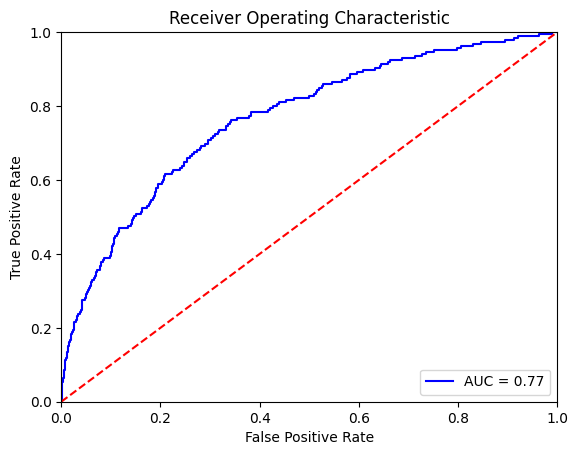

In [32]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = y_pred_proba
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(array([3808., 1389.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

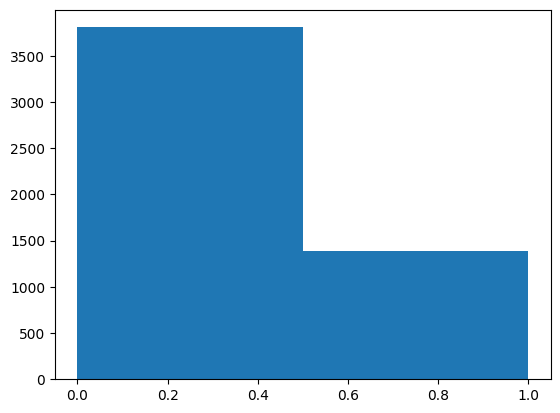

In [33]:
plt.hist(y_pred, bins=2)

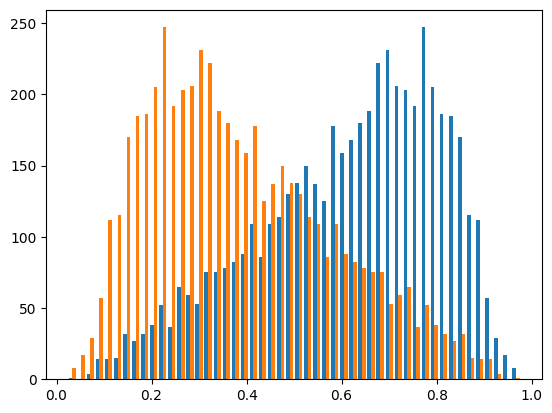

In [34]:
plt.hist(y_pred_proba, bins=50)
plt.show()

## Создание файла решения

In [36]:
X = pd.read_parquet("test_sber.parquet")
X.drop(columns = ["sample_ml_new", "id", 'feature756', 'feature642'], inplace = True)

In [37]:
pred = model.predict_proba(X)

pred = pred[:, 1]
pred_binary = (pred >= 0.1).astype(int)

In [39]:
submission = pd.read_csv("sample_submission.csv")
submission.head(3)

,id,target_bin,target_prob
0,3,0,0.03
1,4,0,0.03
2,12,1,0.03


In [40]:
submission["target_prob"] = pred
submission["target_bin"] = pred_binary
submission.head(3)

,id,target_bin,target_prob
0,3,1,0.259504
1,4,1,0.307778
2,12,1,0.403074


In [41]:
submission.to_csv("submission_14_03.csv", index=False)